In this notebook we will implement a simplified version of the DCM model, in order to generate data for subsequent examples.

In [1]:
import numpy
# use a consistent seed so that everyone has the same data
numpy.random.seed(1000)

import os,sys
%matplotlib inline
import matplotlib.pyplot as plt
sys.path.insert(0,'../utils')
from mkdesign import create_design_singlecondition
from graph_utils import show_graph_from_adjmtx
import math
from nipy.modalities.fmri.hemodynamic_models import spm_hrf,compute_regressor
import scipy.interpolate

results_dir = os.path.abspath("../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)


In [2]:
# first let's build the model without the bilinear influence (aka PPI)
# after http://spm.martinpyka.de/?p=81
nregions=5
z=numpy.zeros(nregions)

# intrinsic connectivity
A=numpy.zeros((z.shape[0],z.shape[0]))
A=numpy.diag(numpy.ones(z.shape[0])*-1)
# add some structure
#A=A + numpy.diag(numpy.ones(z.shape[0]-1),k=-1)
A[2,1]=1
A[3,1]=1
B=numpy.zeros(A.shape)
B[2,0]=1
B[4,0]=1

C=numpy.zeros((z.shape[0],1))
C[0]=1
u=0

print A
print B
print C

# we are assuming a 1 second TR for the resulting data
# but the neural data are at a 1/16 millisecond time resolution
stepsize=.01
tslength=300
timepoints=numpy.arange(0,tslength,stepsize)

# create a blocked design
d,design=create_design_singlecondition(blockiness=1.0,deslength=tslength,blocklength=20,offset=20)

u=scipy.interpolate.griddata(numpy.arange(1,d.shape[0]),d,timepoints,fill_value=0)

def dcm_model(t,z,A,B,C,u):
    ut=numpy.abs(timepoints - t).argmin() 
    return (A.dot(z)+ u[ut]*B.dot(z) + C.dot(u[ut]).T)[0] 

def mk_dcm_dataset(timepoints,z,noise_sd):
    data=numpy.zeros((len(timepoints),len(z)))
    for i in range(1,len(timepoints)):
        data[i,:]=data[i-1,:] + dcm_model(timepoints[i],data[i-1,:],A,B,C,u)  + numpy.random.randn(len(z))*noise_sd 
    hrf=spm_hrf(stepsize,oversampling=1)
    data_conv=numpy.zeros(data.shape)
    for i in range(len(z)):
        data_conv[:,i]=numpy.convolve(data[:,i],hrf)[:data.shape[0]]        
    return data,data_conv    

[[-1.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.]
 [ 0.  1.  0. -1.  0.]
 [ 0.  0.  0.  0. -1.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]]
[[ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


In [3]:
noise_sd=2
data,data_conv=mk_dcm_dataset(timepoints,z,noise_sd)
numpy.savez(os.path.join(results_dir,'dcmdata.npz'),data=data_conv,A=A,B=B,C=C,u=u,d=d,design=design)

correlation matrix
[[ 1.         -0.09707085  0.9631521   0.00367084  0.98511904]
 [-0.09707085  1.          0.08479289  0.71148747 -0.06830046]
 [ 0.9631521   0.08479289  1.          0.12912149  0.95596707]
 [ 0.00367084  0.71148747  0.12912149  1.          0.03603157]
 [ 0.98511904 -0.06830046  0.95596707  0.03603157  1.        ]]
partial r^2 matrix
[[  0.00000000e+00   0.00000000e+00   1.88851794e-01   0.00000000e+00
    4.87627057e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.12385351e-02
    0.00000000e+00]
 [  1.88851794e-01   0.00000000e+00   0.00000000e+00   1.06233643e-04
    8.92322420e-02]
 [  0.00000000e+00   1.12385351e-02   1.06233643e-04   0.00000000e+00
    0.00000000e+00]
 [  4.87627057e-01   0.00000000e+00   8.92322420e-02   0.00000000e+00
    0.00000000e+00]]


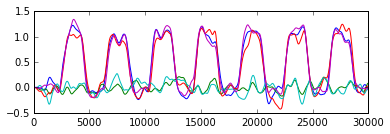

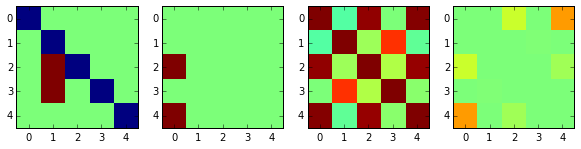

In [4]:
plt.subplot(211)
plt.plot(data_conv)
cc=numpy.corrcoef(data_conv.T)
print 'correlation matrix'
print cc
from sklearn.covariance import GraphLassoCV
import matplotlib.colors

glasso=GraphLassoCV()
glasso.fit(data_conv)
from pcor_from_precision import pcor_from_precision
pcor=pcor_from_precision(glasso.precision_)
print 'partial r^2 matrix'
print pcor**2

plt.figure(figsize=(10,5))
plt.subplot(141)
plt.imshow(A,interpolation='nearest',norm=matplotlib.colors.Normalize(vmin=-1,vmax=1))
plt.subplot(142)
plt.imshow(B,interpolation='nearest',norm=matplotlib.colors.Normalize(vmin=-1,vmax=1))
plt.subplot(143)
plt.imshow(cc,interpolation='nearest',norm=matplotlib.colors.Normalize(vmin=-1,vmax=1))
plt.subplot(144)
plt.imshow(pcor**2,interpolation='nearest',norm=matplotlib.colors.Normalize(vmin=-1,vmax=1))


###Show the true graph

[(0, 2), (0, 4), (1, 2), (1, 3), ('u', 0)]
Black: input
Red: unmodulated
Blue: modulated


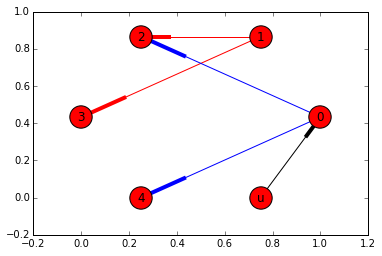

In [5]:
gr=show_graph_from_adjmtx(A,B,C)